In [17]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as ss
from collections import Counter
import math
from scipy import stats

In [2]:
sns.set(style="ticks")

In [3]:
player_df = pd.read_csv(r'C:\Users\Peanut\Downloads\players_20.csv\players_20.csv')

In [4]:
numcols = ['overall', 'potential', 'attacking_crossing', 'attacking_finishing', 'attacking_short_passing',
          'skill_long_passing', 'dribbling', 'skill_ball_control', 'movement_acceleration',
          'movement_sprint_speed', 'movement_agility', 'power_stamina', 'value_eur', 'wage_eur']

In [5]:
catcols = ['short_name', 'club', 'nationality', 'preferred_foot', 'player_positions', 'body_type']

In [6]:
player_df = player_df[numcols + catcols]

In [7]:
player_df.head()

,overall,potential,attacking_crossing,attacking_finishing,attacking_short_passing,skill_long_passing,dribbling,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,power_stamina,value_eur,wage_eur,short_name,club,nationality,preferred_foot,player_positions,body_type
0,94,94,88,95,92,92,96.0,96,91,84,93,75,95500000,565000,L. Messi,FC Barcelona,Argentina,Left,"RW, CF, ST",Messi
1,93,93,84,94,83,77,89.0,92,89,91,87,85,58500000,405000,Cristiano Ronaldo,Juventus,Portugal,Right,"ST, LW",C. Ronaldo
2,92,92,87,87,87,81,95.0,95,94,89,96,81,105500000,290000,Neymar Jr,Paris Saint-Germain,Brazil,Right,"LW, CAM",Neymar
3,91,93,13,11,43,40,NaN,30,43,60,67,41,77500000,125000,J. Oblak,Atlético Madrid,Slovenia,Right,GK,Normal
4,91,91,81,84,89,83,94.0,94,94,88,95,84,90000000,470000,E. Hazard,Real Madrid,Belgium,Right,"LW, CF",Normal


In [10]:
corr = player_df.corr()

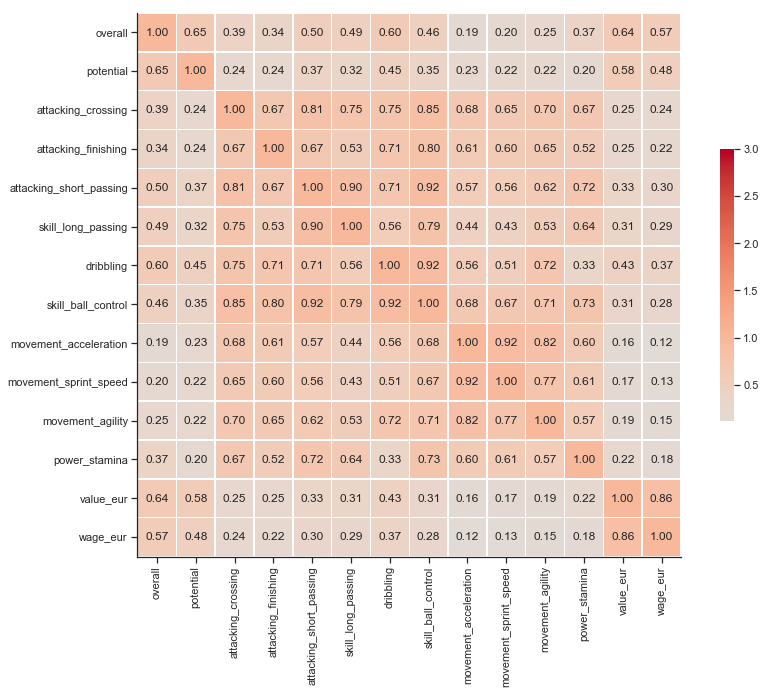

In [11]:
g = sns.heatmap(corr, vmax=3, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(14,10)

plt.show()

In [18]:
def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted

In [20]:
def conditional_entropy(x, y):
# entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [14]:
def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=(20,20))#kwargs.get('figsize',None))
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'), cmap='coolwarm')
        plt.show()
    if return_results:
        return corr

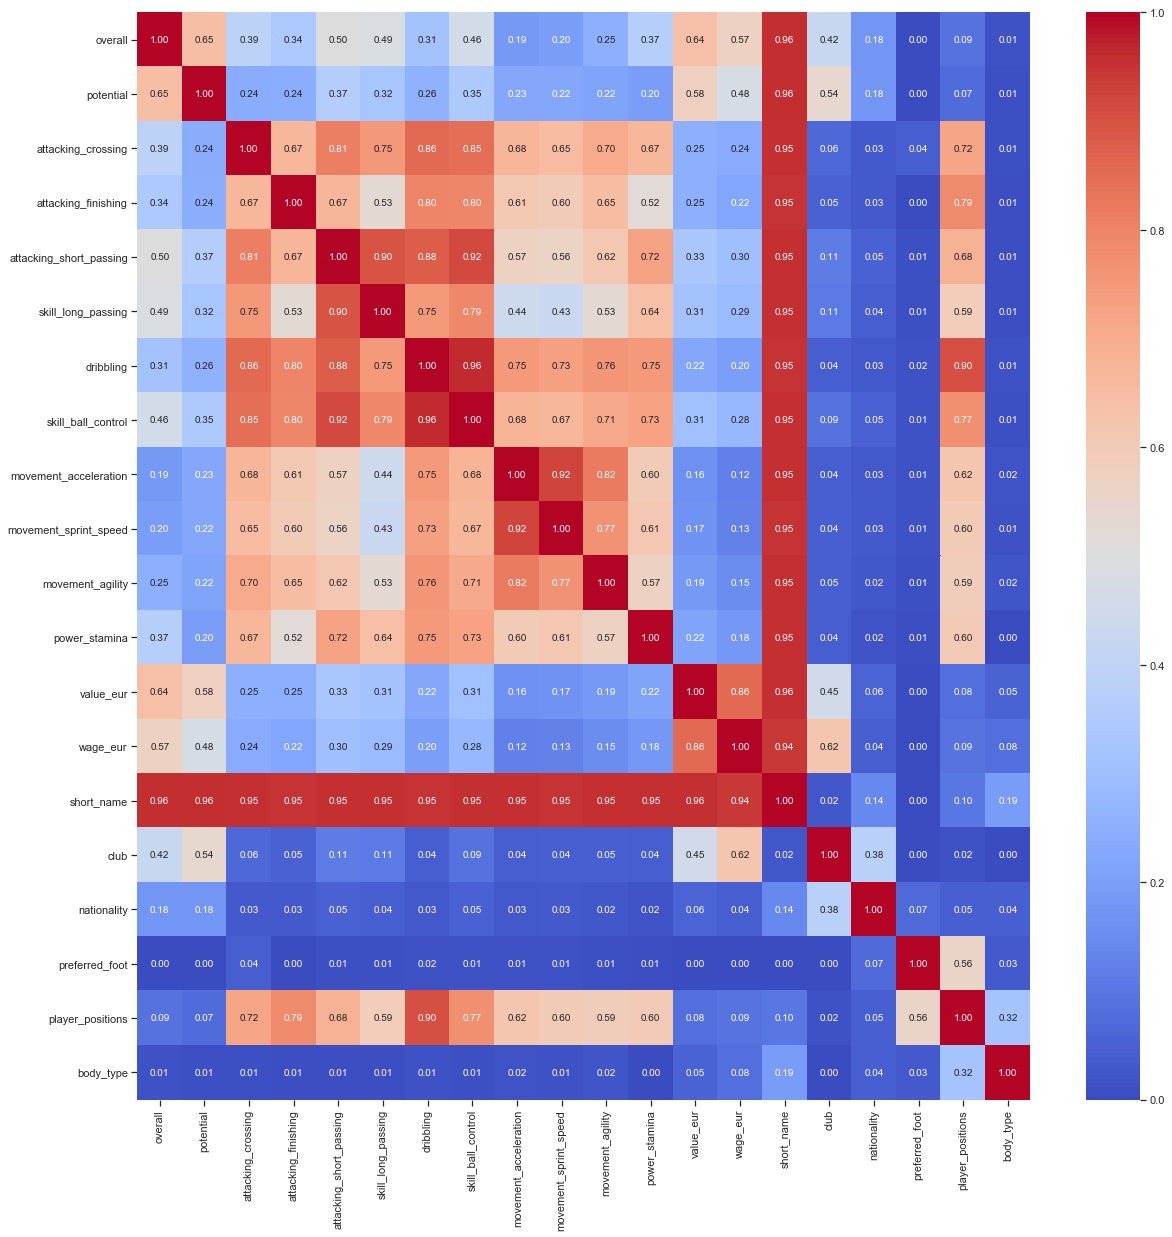

In [21]:
player_df = player_df.fillna(0)
results = associations(player_df,nominal_columns=catcols,return_results=True)

In [35]:
filtered_player_df = player_df[(player_df['club'].isin(['FC Barcelona', 'Paris Saint-Germain',
       'Manchester United', 'Manchester City', 'Chelsea', 'Real Madrid','FC Porto','FC Bayern München'])) &
                      (player_df['nationality'].isin(['England', 'Brazil', 'Argentina',
       'Brazil', 'Italy','Spain','Germany']))
                     ]

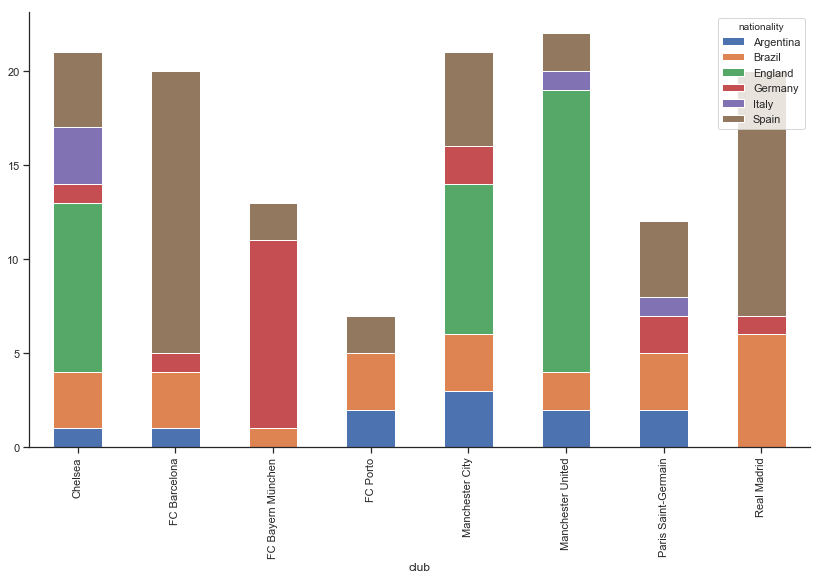

In [34]:
df_plot = filtered_player_df.groupby(['club', 'nationality']).size().reset_index().pivot(columns='club', index='nationality', values=0).reset_index()

g = df_plot.set_index('nationality').T.plot(kind='bar', stacked=True, 
            color=sns.color_palette())
sns.despine()
g.figure.set_size_inches(14,8)
    
plt.show()

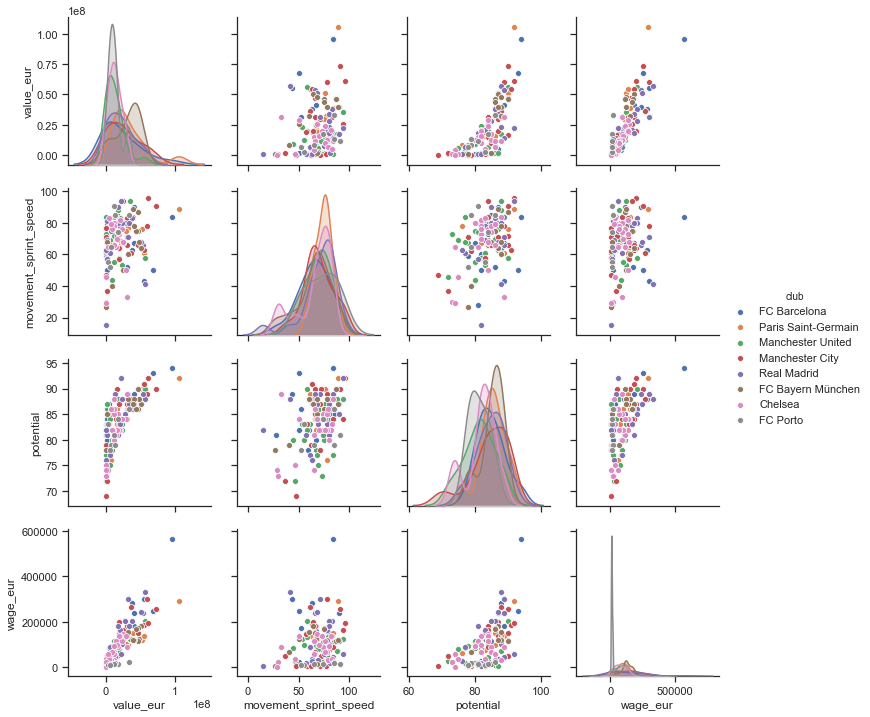

In [36]:
# Single line to create pairplot
g = sns.pairplot(filtered_player_df[['value_eur','movement_sprint_speed','potential','wage_eur', 'club']], hue='club')

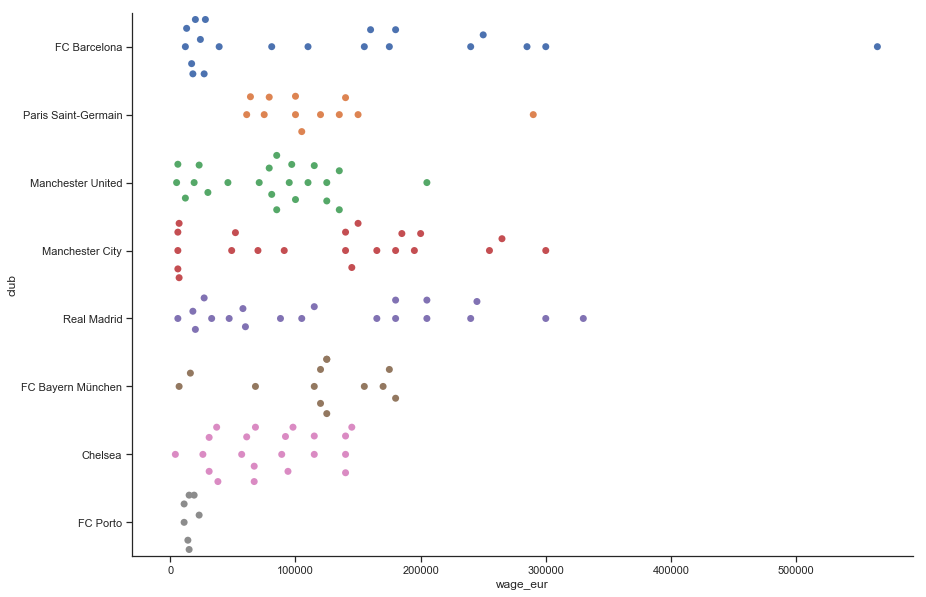

In [37]:
# Plot beeswarm with x as O3

g = sns.swarmplot(y = "club",
              x = 'wage_eur', 
              data = filtered_player_df,
              # Decrease the size of the points to avoid crowding 
              size = 7)

# remove the top and right line in graph
sns.despine()
g.figure.set_size_inches(14,10)
# Give a descriptive title

plt.show()

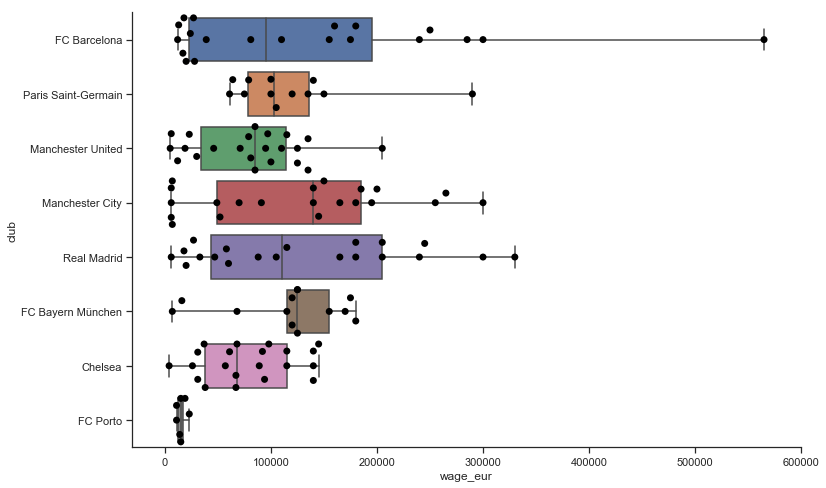

In [27]:
g = sns.boxplot(y = "club",
              x = 'wage_eur',
              data = filtered_player_df, whis=np.inf)
g = sns.swarmplot(y = "club",
              x = 'wage_eur',
              data = filtered_player_df,
              # Decrease the size of the points to avoid crowding
              size = 7,color = 'black')
# remove the top and right line in graph
sns.despine()
g.figure.set_size_inches(12,8)
plt.show()

C:\Users\Peanut\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


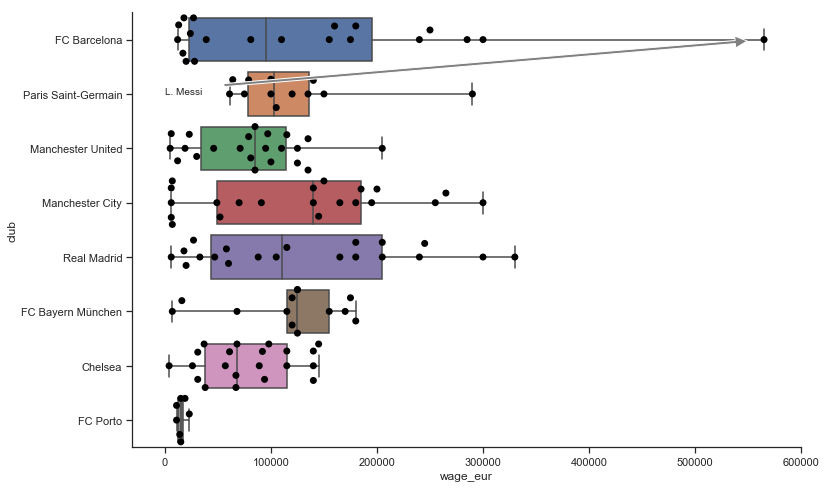

In [33]:
max_wage = filtered_player_df.wage_eur.max()
max_wage_player = filtered_player_df[(player_df['wage_eur'] == max_wage)]['short_name'].values[0]
g = sns.boxplot(y = "club",
              x = 'wage_eur',
              data = filtered_player_df, whis=np.inf)
g = sns.swarmplot(y = "club",
              x = 'wage_eur',
              data = filtered_player_df,
              # Decrease the size of the points to avoid crowding
              size = 7,color='black')
# remove the top and right line in graph
sns.despine()
# Annotate. xy for coordinate. max_wage is x and 0 is y. In this plot y ranges from 0 to 7 for each level
# xytext for coordinates of where I want to put my text
plt.annotate(s = max_wage_player,
             xy = (max_wage,0),
             xytext = (350,1),
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'gray', 'width': 3, 'shrink': 0.03},
             backgroundcolor = 'white')
g.figure.set_size_inches(12,8)
plt.show()